In [123]:
import pickle

with open('user_behavior.pkl', 'rb') as f:
    user_behavior = pickle.load(f)

with open('kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

with open('application_traffic_sum.pkl', 'rb') as f:
    application_traffic_sum = pickle.load(f)

with open('kmeans_experience_model.pkl', 'rb') as f:
    kmeans_experience_model = pickle.load(f)

with open('experience_cluster_labels.pkl', 'rb') as f:
    experience_cluster_labels = pickle.load(f)

with open('aggregated_df.pkl', 'rb') as f:
    aggregated_df = pickle.load(f)

In [124]:
import numpy as np
import pandas as pd

Task4 - Satisfaction Analysis:

In [125]:
least_engaged_cluster = kmeans.cluster_centers_[np.argmin(kmeans.cluster_centers_[:, 0])].reshape(1, -1)
worst_experience_cluster = kmeans_experience_model.cluster_centers_[np.argmin(kmeans_experience_model.cluster_centers_[:, 0])].reshape(1, -1)

In [126]:
if worst_experience_cluster.shape[1] != 3:
    raise ValueError("Worst experience cluster center not found")

In [127]:
print(least_engaged_cluster.shape)
print(worst_experience_cluster.shape)


(1, 3)
(1, 3)


In [128]:
user_behavior['engagement_score'] = (user_behavior['Total DL (Bytes)'] + user_behavior['Total UL (Bytes)']) / user_behavior['Total Session Duration']
user_behavior['experience_score'] = user_behavior['Dur. (ms)'] / user_behavior['Total Session Duration']

In [129]:
least_engaged_cluster = least_engaged_cluster[:, :3]  
engagement_scores = np.linalg.norm(user_behavior[['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']] - least_engaged_cluster, axis=1)
experience_scores = np.linalg.norm(user_behavior[['Dur. (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']] - worst_experience_cluster, axis=1)

In [130]:
satisfaction_score = (0.6 * engagement_scores) + (0.4 * experience_scores)

user_behavior['satisfaction_score'] = satisfaction_score

In [131]:
top_10_satisfied_customers = user_behavior.nlargest(10, 'satisfaction_score')
print(top_10_satisfied_customers)

               Bearer Id   Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
MSISDN/Number                                                              
3.362632e+10        1084  81324722.0      4.942993e+11      4.501432e+10   
3.361489e+10          17   9966898.0      8.156743e+09      6.894830e+08   
3.376054e+10          15   9279434.0      7.811295e+09      7.034786e+08   
3.362578e+10          17  18553754.0      7.770043e+09      7.295774e+08   
3.367588e+10          15   4865947.0      7.309542e+09      5.815688e+08   
3.365973e+10          16   4035428.0      7.081602e+09      6.242603e+08   
3.366646e+10          11   4536757.0      6.903440e+09      4.050610e+08   
3.376041e+10          12   5321667.0      6.610852e+09      5.215189e+08   
3.366471e+10          11   2927785.0      6.400774e+09      4.712445e+08   
3.369879e+10          11   5169128.0      6.010556e+09      5.303431e+08   

               Social Media DL (Bytes)  Social Media UL (Bytes)  \
MSISDN/Number       

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Split data into training and testing sets
X = user_behavior[['engagement_score', 'experience_score']]
y = user_behavior['satisfaction_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality reduction using PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Build a linear regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.0854095381774086e+17


In [139]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor model
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Decision Tree): {mse}')

Mean Squared Error (Decision Tree): 3.629454844187775e+17


In [134]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_values = []

for train_index, test_index in kf.split(X_train_pca):
    X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = LinearRegression()
    model.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model.predict(X_test_fold)
    mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
    
    mse_values.append(mse_fold)

print("Average MSE across folds:", np.mean(mse_values))

Average MSE across folds: 3.084895743925757e+18


In [140]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (Random Forest): {mse}')


Mean Squared Error (Random Forest): 1.6502627727927777e+18


In [ ]:
from sklearn.svm import SVR

# Create an SVM regressor model
model = SVR(kernel='rbf', C=1e3, epsilon=0.1)

# Train the model
model.fit(X_train_pca, y_train)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (SVM): {mse}')

Clustering Satisfaction & Experience:

In [135]:
from sklearn.cluster import KMeans

# Select the relevant columns
X = user_behavior[['engagement_score', 'experience_score']]

In [136]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the relevant columns
X = user_behavior[['engagement_score', 'experience_score']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run k-means clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the user_behavior dataframe
user_behavior['cluster_label'] = cluster_labels

cluster_scores = user_behavior.groupby('cluster_label')[['satisfaction_score', 'experience_score']].mean()

# Print the results
print(cluster_scores)

               satisfaction_score  experience_score
cluster_label                                      
0                    6.335183e+08               1.0
1                    7.295689e+08               1.0


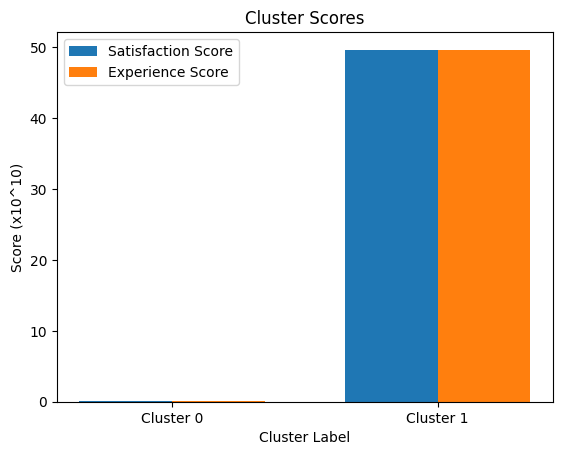

In [137]:
import matplotlib.pyplot as plt
import numpy as np

# Define the scores for each cluster
cluster_scores = np.array([
    [6.375651e+08, 6.375651e+08],  # Cluster 0
    [4.963447e+11, 4.963447e+11]   # Cluster 1
])

# Scale the values down
scaled_scores = cluster_scores / 1e10

# Define the labels
cluster_labels = ['Cluster 0', 'Cluster 1']
score_labels = ['Satisfaction Score', 'Experience Score']

# Create the bar chart
x = np.arange(len(cluster_labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scaled_scores[:, 0], width, label=score_labels[0])
rects2 = ax.bar(x + width/2, scaled_scores[:, 1], width, label=score_labels[1])

# Set the labels and title
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Score (x10^10)')
ax.set_title('Cluster Scores')
ax.set_xticks(x)
ax.set_xticklabels(cluster_labels)
ax.legend()

plt.show()


In [138]:
import pickle

# Assuming you have the necessary data in the 'user_behavior' dataframe
data_to_save = user_behavior[['engagement_score', 'experience_score', 'satisfaction_score']]

# Save the data to a Pickle file
with open('task4_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)